# PROGRAM FDinplane
2-d rectangle o-4 stress velocity inplane

Stefan Nielsen - June 2018

**For goole colab only, turn the two cells below in "code" and run them:**

from google.colab import files
uploaded = files.upload()
# a widget "browse" will appear, click it and upload the two companion filed FDpar.py and FDarrays.py

%pip install -q "ipympl==0.9.6" "ipywidgets==8.1.3" "matplotlib==3.8.4"
from google.colab import output
output.enable_custom_widget_manager()

Skip the above two cells when using MYBINDER, and directly start below:

In [1]:
# Stefan Nielsen 2018 - various lib import:
#%matplotlib inline
#%matplotlib notebook
#%config InlineBackend.figure_format = 'svg'
import os
import time
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
#matplotlib.interactive(True)
from pylab import plot, xlabel, ylabel
from pylab import *
#from scipy import arange
#from IPython import display
from matplotlib import animation, rc
import matplotlib.ticker as ticker
from importlib import reload
#####

initialise parameters and arrays, importing from local files:

In [2]:
from FDfpar import *       #
from FDarrays import *     #

mu[:,:]=28.e9
lam[:,:]=28.e9
rho[:,:]=2700.
rn=9./8.;rnn=-1/24.;
nxs=30;nys=2;
strini[:]=10.0e6;broken[:]=0;nbr=0
######
Vs= np.sqrt(mu[0,0]/rho[0,0])
Vp= np.sqrt((2*mu[0,0]+lam[0,0])/rho[0,0])
# Poisson's ratio from Vp/Vs
nu = ((Vp / Vs)**2 - 2) / (2 * ((Vp / Vs)**2 - 1))
# Viktorov approximation
VRayleigh = Vs * (0.862 + 1.14 * nu) / (1 + nu)



define functions:

In [3]:
def stress_o4(s11,s22,s12):
    for i in range(2,nx-2):
        for j in range(2,ny-2):
            s11[j,i]=  s11[j,i] + (dt/dx) * (                   \
            (lam[j,i]+2*mu[j,i]) *                              \
            (rn*(v1[j,i]-v1[j,i-1])+rnn*(v1[j,i+1]-v1[j,i-2]))  \
            +lam[j,i] *                                         \
            (rn*(v2[j+1,i]-v2[j,i])+rnn*(v2[j+2,i]-v2[j-1,i])) )
            #
            s22[j,i]=s22[j,i]+ (dt/dx)*(                        \
            (lam[j,i]+2*mu[j,i]) *                              \
            (rn*(v2[j+1,i]-v2[j,i])+rnn*(v2[j+2,i]-v2[j-1,i]))  \
            +lam[j,i] *                                         \
            (rn*(v1[j,i]-v1[j,i-1])+rnn*(v1[j,i+1]-v1[j,i-2])  ) )
    for i in range(2,nx-2):
        for j in range(2,ny-2):
            s12[j,i]=  s12[j,i] + mu[j,i]*(dt/dx)*(               \
            (rn*(v1[j,i]-v1[j-1,i])+rnn*(v1[j+1,i]-v1[j-2,i]))+    \
            (rn*(v2[j,i+1]-v2[j,i])+rnn*(v2[j,i+2]-v2[j,i-1]))  )

In [4]:
def stress_o2(s11,s22,s12):
    for i in [1,nx-2]:
        for j in [1,ny-2]:
            s11[j,i]=  s11[j,i] + (dt/dx) * (                   \
            (lam[j,i]+2*mu[j,i]) *(v1[j,i]-v1[j,i-1])                                 \
            +lam[j,i]*(v2[j+1,i]-v2[j,i]) )
            #
            s22[j,i]=s22[j,i]+ (dt/dx)*(                        \
            (lam[j,i]+2*mu[j,i])*(v2[j+1,i]-v2[j,i])                                 \
            + lam[j,i]*(v1[j,i]-v1[j,i-1])  )
    for i in [1,nx-2]:
        for j in [1,ny-2]:
            s12[j,i]=  s12[j,i] + mu[j,i]*(dt/dx)*(            \
            (v1[j,i]-v1[j-1,i])+(v2[j,i+1]-v2[j,i])     )

In [5]:
def vel_o4(v1,v2):
    for i in range(2,nx-2):
        for j in range(2,ny-2):
            v1[j,i]= v1[j,i]+(1.-diss)*(dt/(dx*rho[j,i]))*(          \
             rn*(s11[j,i+1]-s11[j,i])+rnn*(s11[j,i+2]-s11[j,i-1])     \
            +rn*(s12[j+1,i]-s12[j,i])+rnn*(s12[j+2,i]-s12[j-1,i])   )
            #
            v2[j,i]= v2[j,i]+(1.-diss)*(dt/(dx*rho[j,i]))*(            \
             rn*(s22[j,i]-s22[j-1,i])+rnn*(s22[j+1,i]-s22[j-2,i])     \
            +rn*(s12[j,i]-s12[j,i-1])+rnn*(s12[j,i+1]-s12[j,i-2]) )

In [6]:
def vel_o2(v1,v2):
    for i in [1,nx-2]:
        for j in [1,ny-2]:
            v1[j,i]= v1[j,i]+(1.-diss)*(dt/(dx*rho[j,i]))*(            \
             (s11[j,i+1]-s11[j,i]) + (s12[j+1,i]-s12[j,i]) )
            #
            v2[j,i]= v2[j,i]+(1.-diss)*(dt/(dx*rho[j,i]))*(            \
             (s22[j,i]-s22[j-1,i]) + (s12[j,i]-s12[j,i-1]) )

In [7]:
def ssource1(s11,s22):
    rf=0.;nxs=64;nys=64;
    rf=(1./tau_s)*exp(-((float(it)*dt-2.*tau_s)/tau_s)**2)
    s22[nxs,nxs]=s22[nys,nxs]+rf
    s11[nys,nxs]=s11[nys,nxs]+rf

In [8]:
def plotvel():
    mava=np.max(np.abs(v1))

    fig=plt.figure(figsize=(6,3))
    ax1 = plt.subplot2grid((1,8), (0,0), colspan=7)

    p = ax1.pcolor(v1, cmap=cm.RdBu,vmin=-mava,vmax=mava);
    tim=it*dt
    ax1.set_aspect('equal', adjustable='box')
    fig.suptitle('time=%1.3f' %tim)
    plt.show()

In [9]:
def plots12():
    from matplotlib.colors import SymLogNorm
    sinv=-s12
    mava=np.max(np.abs(sinv))
    norm = SymLogNorm(linthresh=1e-1, linscale=1, vmin=-mava, vmax=mava)
    fig=plt.figure(figsize=(6,3))
    ax1 = plt.subplot2grid((1,8), (0,0), colspan=7)

    p = ax1.pcolor(sinv, cmap=cm.RdBu, norm=norm);
    tim=it*dt
    ax1.set_aspect('equal', adjustable='box')
    fig.suptitle('time=%1.3f' %tim)
    plt.show()

In [16]:
def plot_combined(v1, s12, it, dt):
    from matplotlib.colors import SymLogNorm
    tim = it * dt
    
    # Compute limits and color normalization
    mava_v = np.max(np.abs(v1))
    mava_s = np.max(np.abs(s12))
    norm_s = SymLogNorm(linthresh=1e5, linscale=1, vmin=-mava_s, vmax=mava_s)

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3.2), constrained_layout=True)

    # --- Left: Particle velocity ---
    p1 = ax1.pcolor(v1, cmap=cm.RdBu, vmin=-mava_v, vmax=mava_v)
    ax1.set_title("Particle velocity v1")
    ax1.set_aspect('equal', adjustable='box')
    cbar1 = fig.colorbar(p1, ax=ax1, orientation='horizontal', pad=0.1)
    cbar1.set_label("v1 amplitude")

    # --- Right: Shear stress ---
    p2 = ax2.pcolor(-s12, cmap=cm.RdBu, norm=norm_s)
    ax2.set_title("Shear stress")
    ax2.set_aspect('equal', adjustable='box')
    cbar2 = fig.colorbar(p2, ax=ax2, orientation='horizontal', pad=0.1)
    cbar2.set_label("s12 amplitude")

    # Overall title
    fig.suptitle(f"time = {tim:.3f}", fontsize=12)

    plt.show()

In [11]:
def ssource2(s11,s22):
    # add here an instant dislocation 
    s12[63,50:200]=-1

In [12]:
def friction_sw(j,i):
    # Slip- and/or rate-weakening ('srw' or '')
    if FricType == 'srw' or FricType == '':
        # dd from slip weakening
        if delta == 0.0:
            dd = 0.0
        else:
            dd = 1.0 - slip[i] / delta
            if dd < 0.0: dd = 0.0
            if dd > 1.0: dd = 1.0

        # dv from velocity weakening
        if vcha == 0.0:
            dv = 0.0
        else:
            # Guard against division by zero if vcha + rdis[i] ~ 0
            denom = vcha + rdis[i]
            dv = vcha / denom if denom != 0.0 else 0.0

        if dv > dd:
            dd = dv

    # Pure time-weakening
    elif FricType == 'time':
        dd = 1.0 - float(it - itim[i]) * dt / tau_f
        if dd < 0.0: dd = 0.0
        if dd > 1.0: dd = 1.0

    # Enforce shear friction
    friction = dd * peak_12[i]
    s12[j, i] = friction - strini[i]

In [18]:
def rupture():
    global nbr
    """
    Define rupture velocity here (rvr), and the position of the fault plane on the grid (j):
    """
    j = 63
    rvr=Vs*np.sqrt(2.0)
    #rvr=0.95*VRayleigh
    RuptureType='imposed'#'spontaneous'
    #####################################################
    for i in range(nx):  # i = 0 .. nx-1 (Fortran: 1..nx)
        # local normals, slip-rate proxy, position/time
        rns = 0.5 * (s22[j, i] + s22[j - 1, i])
        rdis[i] = v1[j, i] - v1[j - 1, i]
        rpos = float(i - nxs) * dx            # if nxs is 0-based
        rtim = float(it) * dt

        # Rupture velocity imposed:
        if (RuptureType == 'imposed'
            and rvr * rtim > rpos
            and rvh * (rtim - tau_s) < rpos
            and broken[i] == 0
            and rpos > 0.0):
            peak_12[i] = (s12[j, i] + strini[i]) * 0.99
            broken[i] = 1
            itim[i] = it
            rdis[i] = 0.0
            nbr += 1

        if broken[i] == 1:
            # Friction update on broken points
            friction_sw(j,i)
            
            # Healing criterion
            #if rvh * (rtim - tau_s) > rpos:
            #    broken[i] = 0
            #    rdis[i] = 0.0
            #    nbr -= 1
        else:
            # Not broken: reset local rdis contribution
            rdis[i] = 0.0

        # Cumulative slip
        slip[i] = slip[i] + rdis[i] * dt


start main time loop:

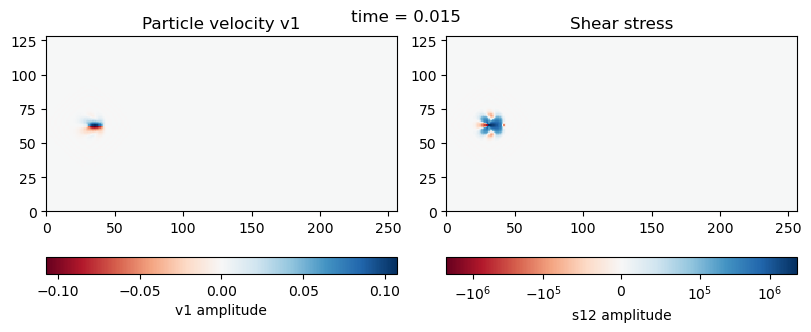

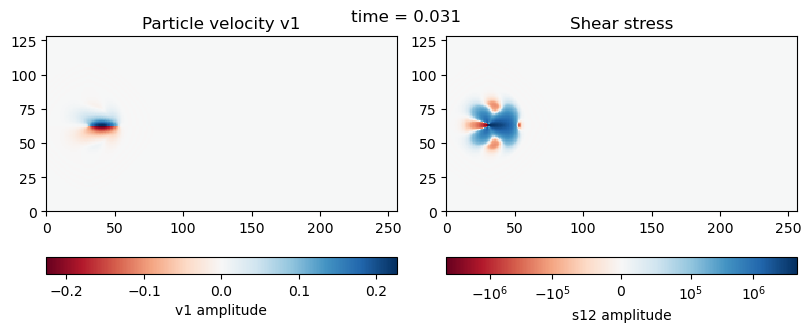

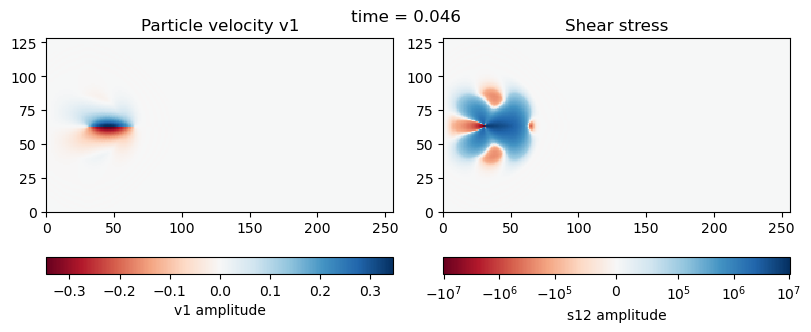

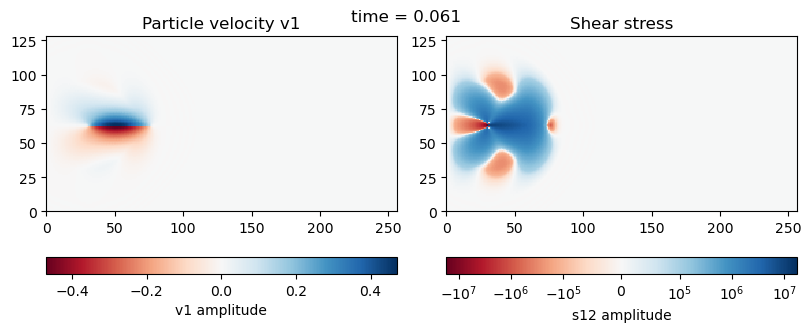

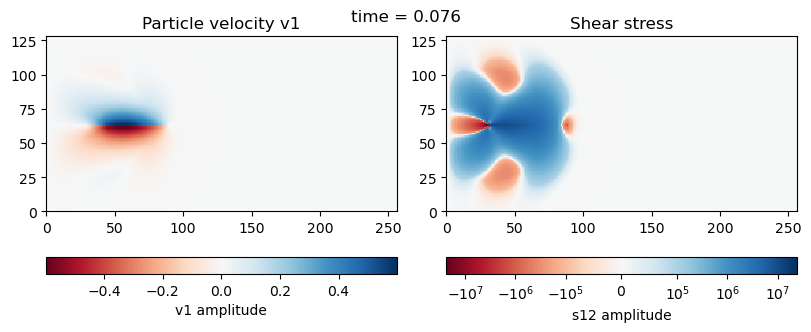

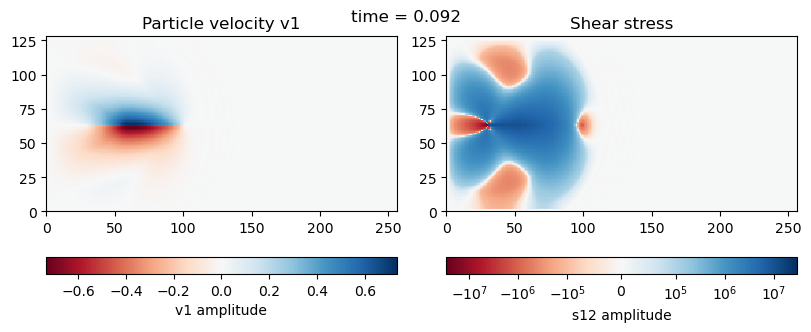

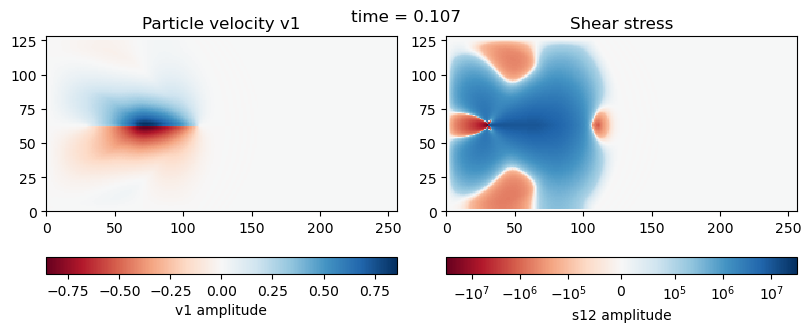

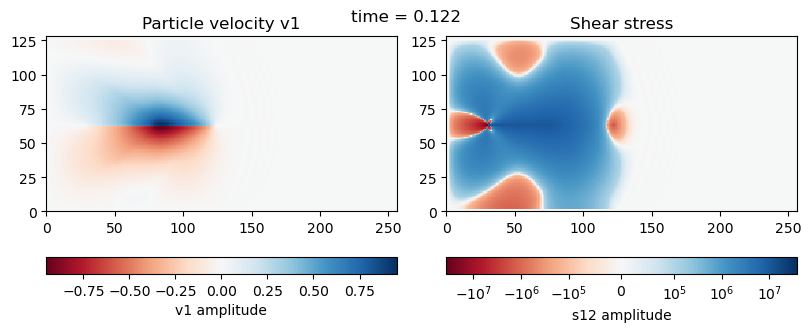

In [ ]:
it=0;is1=0
ntime = 550; nos2=50;
startt=time.time()
v1s=[]
v1[:,:]=0; v2[:,:]=0; 
s11[:,:]=0; s22[:,:]=0; s12[:,:]=0;
rdis[:]=0; slip[:]=0; broken[:]=0; itim[:]=0;
rtim=0.0; it=0;
try:
    while(it < ntime):
        it = it+1;
        stress_o4(s11,s22,s12)
        stress_o2(s11,s22,s12)
        #ssource2(s11,s22)
        rupture()
        vel_o4(v1,v2)
        vel_o2(v1,v2)
        is1 = is1+1
        if (is1 > nos2):
            #plotvel();
            #plots12();
            plot_combined(v1, s12, it, dt)
            is1=0
            #print ("it="+str(it)+" — time="+str(round(it*dt,3))+" s")
        v1s.append(v1[63,127])
except KeyboardInterrupt:
    pass

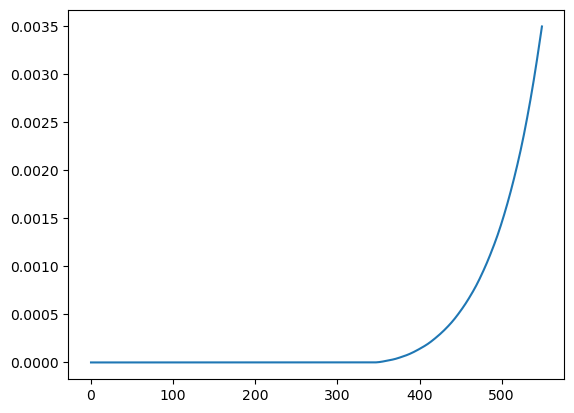

In [15]:
fig,ax=plt.subplots()
ax.plot(v1s)